In [1]:
# Cell 1: Data Loading, Preprocessing, and Stratified Split for Neg+Pos only
import pandas as pd
import numpy as np
from collections import defaultdict

# 1. Load the dataset, force Sample and AB as strings to avoid mixed types
df = pd.read_csv(
    './data300.csv',
    dtype={'Sample': str, 'AB': str},
    low_memory=False,
)
df['Sample'] = df['Sample'].astype(str)

# 2. Normalize the Group column to exactly "Neg", "Pos", or "Fungi"
df['Group'] = df['Group'].str.strip().str.lower().map({
    'neg': 'Neg',
    'gram‐negative': 'Neg',
    'gram-negative bacteria': 'Neg',
    'pos': 'Pos',
    'gram‐positive': 'Pos',
    'gram-positive bacteria': 'Pos',
    'yeast': 'Fungi',
    'fungi': 'Fungi',
})
print("All groups before filter:", df['Group'].unique())

# 3. **Filter out fungi** — keep only Gram–negative and Gram–positive
df = df[df['Group'].isin(['Neg','Pos'])].reset_index(drop=True)
print("Groups after filter:", df['Group'].unique())

# 4. Identify intensity columns (first 5 columns metadata)
intensity_cols = df.columns[5:]

# 5. Min–max normalize each spectrum (row) across the intensity columns
X_values = df[intensity_cols].to_numpy(dtype=np.float32)
mins      = X_values.min(axis=1, keepdims=True)
maxs      = X_values.max(axis=1, keepdims=True)
ranges    = np.where(maxs - mins == 0, 1.0, maxs - mins)
X_norm    = (X_values - mins) / ranges   # shape (N, num_wavelengths)

# 6. Encode species labels into integer classes
species_labels   = df['ID'].astype(str).values
unique_species   = sorted(np.unique(species_labels))
label_to_idx     = {lab: i for i, lab in enumerate(unique_species)}
y_full           = np.array([label_to_idx[s] for s in species_labels], dtype=np.int64)
print(f"Total species kept: {len(unique_species)}")  # should be 24

# 7. Build a unique sample_key per biological sample: "<Species>_<SampleID>"
df['sample_key'] = df['ID'].astype(str) + '_' + df['Sample'].astype(str)

# gather unique keys per species
species_to_keys = {
    sp: df.loc[df['ID'] == sp, 'sample_key'].unique().tolist()
    for sp in unique_species
}

# --- the DYNAMIC SPLIT loop ---
np.random.seed(42)
train_keys, val_keys, test_keys = [], [], []

for sp, keys in species_to_keys.items():
    np.random.shuffle(keys)
    if len(keys) == 1:
        train_keys.append(keys[0])
        continue

    test_keys.append(keys[0])
    rem = keys[1:]
    if len(rem) == 1:
        train_keys.append(rem[0])
        continue

    # choose ratio by number of original keys
    if len(keys) > 15:
        train_ratio = 0.7
    else:
        train_ratio = 0.8

    n_train = max(1, int(train_ratio * len(rem)))
    train_keys.extend(rem[:n_train])
    val_keys.extend(rem[n_train:])
    
# 11. Build boolean masks for each split
train_mask = df['sample_key'].isin(train_keys)
val_mask   = df['sample_key'].isin(val_keys)
test_mask  = df['sample_key'].isin(test_keys)

# 12. Slice out X and y for each split
X_train, y_train = X_norm[train_mask], y_full[train_mask]
X_val,   y_val   = X_norm[val_mask],   y_full[val_mask]
X_test,  y_test  = X_norm[test_mask],  y_full[test_mask]

# 13. Sanity checks
print(f"Total spectra: {len(df)}")
print(f"Train spectra: {len(X_train)}, Val spectra: {len(X_val)}, Test spectra: {len(X_test)}")

# 14. Count per species in each split
train_counts = pd.Series(y_train).map(lambda i: unique_species[i]).value_counts().sort_index()
val_counts   = pd.Series(y_val).map(lambda i: unique_species[i]).value_counts().sort_index()
test_counts  = pd.Series(y_test).map(lambda i: unique_species[i]).value_counts().sort_index()

print("\nTrain set species counts:\n", train_counts)
print("\nVal set species counts:\n",   val_counts)
print("\nTest set species counts:\n",  test_counts)


All groups before filter: ['Neg' 'Fungi' 'Pos']
Groups after filter: ['Neg' 'Pos']
Total species kept: 29
Total spectra: 74400
Train spectra: 46500, Val spectra: 19200, Test spectra: 8700

Train set species counts:
 Aba    1500
Ano    3300
Api    3000
Bce    1200
Bfg    1200
Cdi    1200
Cfr    1500
Eae    1500
Ecl    1500
Eco    3900
Efa    2400
Efm    1200
Kox    3300
Kpn    1200
Lmo     900
Mmo    1500
Pae    1200
Pmi    1500
Sal     900
Sau    1200
Sca    1200
Sep    1200
Sgc    1200
Shl    1200
Sho    1200
Sma    1500
Spn    1200
Stm    1500
Svi    1200
Name: count, dtype: int64

Val set species counts:
 Aba     600
Ano     900
Api    1500
Bce     600
Bfg     300
Cdi     600
Cfr     600
Eae     600
Ecl     600
Eco    1800
Efa     900
Efm     600
Kox     900
Kpn     600
Lmo     300
Mmo     600
Pae     600
Pmi     600
Sal     300
Sau     600
Sca     600
Sep     600
Sgc     600
Shl     600
Sho     600
Sma     600
Spn     300
Stm     600
Svi     600
Name: count, dtype: int64

Test set 

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class RamanSpectraDataset(Dataset):
    def __init__(
        self,
        X, y,
        augment: bool = False,
        noise_std: float = 0.01,
        noise_prob: float = 0.5,
        shift_range: int = 5,
        shift_prob: float = 0.5,
        scale_range: tuple[float,float] = (0.9, 1.1),
        scale_prob: float = 0.5,
        drift_prob: float = 0.3
    ):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.augment = augment

        # augmentation hyper‐parameters
        self.noise_std   = noise_std
        self.noise_prob  = noise_prob
        self.shift_range = shift_range
        self.shift_prob  = shift_prob
        self.scale_range = scale_range
        self.scale_prob  = scale_prob
        self.drift_prob  = drift_prob

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        spec = self.X[idx].clone()

        if self.augment:
            # 1) Gaussian noise
            if torch.rand(1).item() < self.noise_prob:
                spec += self.noise_std * torch.randn_like(spec)

            # 2) Random shift ±shift_range
            if torch.rand(1).item() < self.shift_prob:
                shift = torch.randint(-self.shift_range,
                                       self.shift_range + 1,
                                       (1,)).item()
                spec = torch.roll(spec, shifts=shift, dims=0)

            # 3) Random scale
            if torch.rand(1).item() < self.scale_prob:
                lo, hi = self.scale_range
                scale = float(torch.empty(1).uniform_(lo, hi))
                spec *= scale

            # 4) Baseline drift
            if torch.rand(1).item() < self.drift_prob:
                drift = torch.linspace(0, float(torch.randn(1)), spec.size(0))
                spec += drift

            # clip back to [0,1]
            spec = spec.clamp(0.0, 1.0)

        return spec, self.y[idx]


def make_loader(X, y, augment, batch_size=320, num_workers=4, noise_std=0.01):
    """
    Helper to reduce code duplication.  Pass augment=True for train,
    noise_std (and other aug params) get pushed down into the dataset.
    """
    ds = RamanSpectraDataset(
        X, y,
        augment=augment,
        noise_std=noise_std,      # change this if you want more/less noise
        noise_prob=0.5,
        shift_range=5,
        shift_prob=0.5,
        scale_range=(0.9, 1.1),
        scale_prob=0.5,
        drift_prob=0.3
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=augment,      # shuffle only if augmenting (i.e. training)
        num_workers=num_workers,
        pin_memory=True
    )


# Example usage:
batch_size = 384
train_loader = make_loader(X_train, y_train, augment=True,  batch_size=batch_size, noise_std=0.01)
val_loader   = make_loader(X_val,   y_val,   augment=False, batch_size=batch_size)
test_loader  = make_loader(X_test,  y_test,  augment=False, batch_size=batch_size)


In [3]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader

class RamanTransformerClassifier(nn.Module):
    def __init__(self, seq_len, num_classes, d_model=64, nhead=8, dim_feedforward=256, num_layers=2, dropout=0.1):
        """
        Initializes the Transformer-based classifier.
        seq_len: length of the input sequence (number of wavelength points, e.g., 1000)
        num_classes: number of output classes (species)
        d_model: dimensionality of the embedding/transformer model
        nhead: number of heads in multi-head attention
        dim_feedforward: dimensionality of the feedforward network in transformer layers
        num_layers: number of transformer encoder layers
        dropout: dropout rate for transformer layers
        """
        super(RamanTransformerClassifier, self).__init__()
        # Linear projection of input scalar to d_model-dimensional embedding
        self.value_embedding = nn.Linear(1, d_model)
        # Positional encoding (sinusoidal)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # shape [seq_len, 1]
        # Frequencies for sine/cosine positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pos_encoding[:, 0::2] = torch.sin(positions * div_term)  # apply sin to even indices in the embedding
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)  # apply cos to odd indices
        pos_encoding = pos_encoding.unsqueeze(0)  # shape [1, seq_len, d_model] for broadcasting
        # Register as buffer (not a parameter, but part of the state for usage)
        self.register_buffer('pos_encoding', pos_encoding)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
                                                  dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        """
        Forward pass for the model.
        x: input tensor of shape [batch_size, seq_len] containing normalized Raman intensities.
        """
        # Project each intensity value to a d_model-dimensional embedding
        # x is [batch, seq_len]; convert to [batch, seq_len, 1] for linear layer
        x = x.unsqueeze(-1)
        x = self.value_embedding(x)  # now x shape: [batch, seq_len, d_model]

        # Add positional encoding to include wavelength position information
        x = x + self.pos_encoding[:, :x.size(1), :]  # broadcasting over batch dimension

        # Pass through Transformer encoder layers
        x = self.transformer_encoder(x)  # shape remains [batch, seq_len, d_model]

        # Global average pooling over the sequence dimension
        x = x.mean(dim=1)  # shape: [batch, d_model]

        # Final classifier to get class logits
        logits = self.classifier(x)  # shape: [batch, num_classes]

        return logits

# Initialize the model
seq_length = X_train.shape[1]  # this should be 1000 (number of wavelength points)
num_classes = len(unique_species)
model = RamanTransformerClassifier(
    seq_len=seq_length,                                   
    num_classes=num_classes,                                   
    d_model=128,                                    
    nhead=8,                                    
    dim_feedforward=4*128,                                   
    num_layers=4, 
    dropout=0.3)

print(model)


RamanTransformerClassifier(
  (value_embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=29, bias=True)
)


In [4]:
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# 0) Device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model.to(device)

# 1) Build per‐sample weights for class‐balanced sampling
#    y_train is your numpy array of integer labels (0…num_classes-1)
train_labels = y_train  # shape (N_train,)
class_counts = np.bincount(train_labels, minlength=len(unique_species))
class_weights = 1.0 / class_counts               # smaller classes get larger weight
sample_weights = class_weights[train_labels]     # weight for each sample
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

# 2) DataLoaders using on‐the‐fly augmentation & sampler
batch_size = 384

train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,         # <-- replace shuffle=True
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 3) Optimizer, scheduler, loss
learning_rate = 8e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 4) Training hyperparams
num_epochs = 150
patience   = 10

# 5) Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 6) Metric containers & early‐stop tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0


Using device: cuda


In [5]:
%%time
import math
import torch

# ——————————————————————————————————————————————————————————————————————————
# 0) Assumes you’ve already run the cell that defines:
#    • RamanSpectraDataset
#    • X_train, y_train, X_val, y_val, X_test, y_test
#    • Device and model moved to device
#    • optimizer and criterion defined
# ——————————————————————————————————————————————————————————————————————————

# 1) (Re)build DataLoaders here with augmentation on train only
batch_size = 384
train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

# 2) Compute total_steps and warmup
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.15 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 3) Training loop
global_step = 0
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(1, num_epochs+1):
    # — Training —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()       # step LR every batch
        global_step += 1

        # metrics
        train_loss   += loss.item() * X_batch.size(0)
        preds         = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total  += y_batch.size(0)

    avg_train_loss = train_loss / train_total
    train_acc      = train_correct / train_total

    # — Validation —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss    += loss.item() * X_batch.size(0)
            preds        = logits.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total   += y_batch.size(0)

    avg_val_loss = val_loss / val_total
    val_acc      = val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | "
          f"Train Loss={avg_train_loss:.4f}, Acc={train_acc*100:.1f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={val_acc*100:.1f}% | "
          f"LR={current_lr:.2e}")

    # — Early stopping on val_acc —
    if val_acc > best_val_acc:
        best_val_acc     = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in {patience} epochs. Stopping early.")
            break

# restore best model
model.load_state_dict(best_model_state)
print(f"Loaded best model (Val Acc = {best_val_acc*100:.2f}%)")


Epoch 01 | Train Loss=3.3239, Acc=7.7% | Val Loss=3.3098, Acc=9.4% | LR=3.56e-05
Epoch 02 | Train Loss=3.2754, Acc=8.7% | Val Loss=3.2369, Acc=7.6% | LR=7.11e-05
Epoch 03 | Train Loss=3.2229, Acc=11.6% | Val Loss=3.0938, Acc=14.2% | LR=1.07e-04
Epoch 04 | Train Loss=2.8610, Acc=19.6% | Val Loss=2.4540, Acc=27.0% | LR=1.42e-04
Epoch 05 | Train Loss=2.3417, Acc=34.9% | Val Loss=2.1200, Acc=39.0% | LR=1.78e-04
Epoch 06 | Train Loss=2.0539, Acc=45.8% | Val Loss=1.9252, Acc=46.1% | LR=2.13e-04
Epoch 07 | Train Loss=1.8582, Acc=53.5% | Val Loss=1.8642, Acc=50.6% | LR=2.49e-04
Epoch 08 | Train Loss=1.7294, Acc=58.0% | Val Loss=1.7230, Acc=57.5% | LR=2.84e-04
Epoch 09 | Train Loss=1.6364, Acc=61.9% | Val Loss=1.8721, Acc=53.8% | LR=3.20e-04
Epoch 10 | Train Loss=1.5646, Acc=64.5% | Val Loss=1.7427, Acc=58.7% | LR=3.56e-04
Epoch 11 | Train Loss=1.4872, Acc=67.9% | Val Loss=1.6791, Acc=61.2% | LR=3.91e-04
Epoch 12 | Train Loss=1.4225, Acc=70.2% | Val Loss=1.6768, Acc=63.3% | LR=4.27e-04
Epoch 13

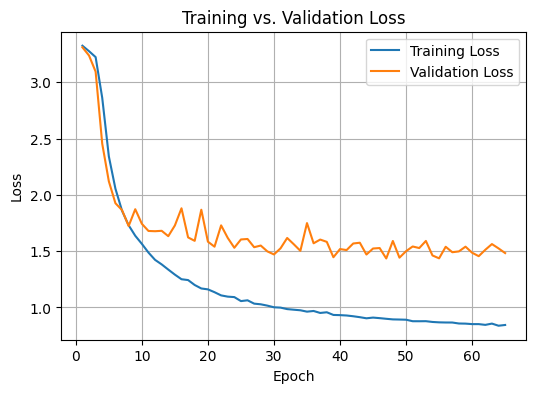

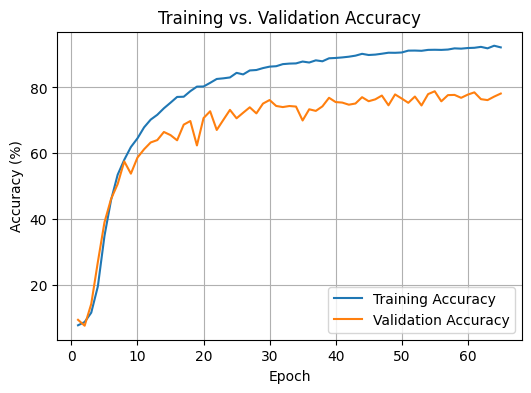

In [6]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)  # total epochs that ran (could be less than num_epochs if early stopped)
epoch_range = range(1, epochs_ran+1)

# Plot Training and Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(epoch_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(epoch_range, np.array(train_accuracies)*100, label='Training Accuracy')
plt.plot(epoch_range, np.array(val_accuracies)*100, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


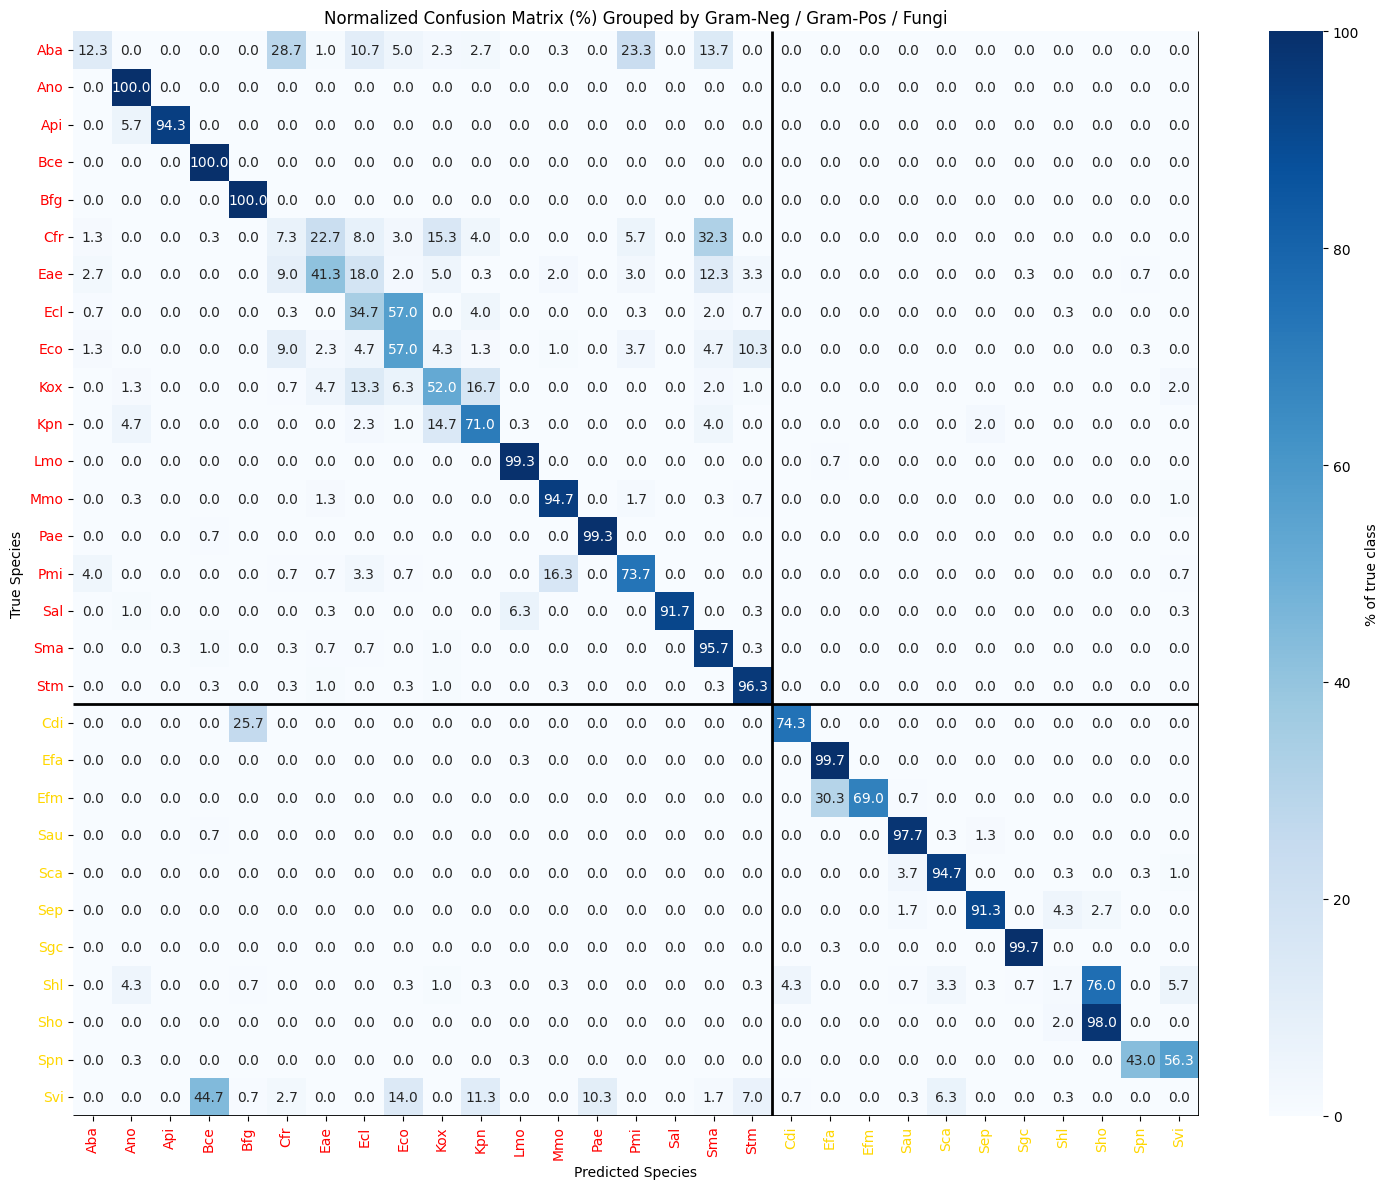

Test Accuracy: 72.06% (6269/8700)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure model is in eval mode
model.eval()

# Collect true & predicted labels on the test set
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        # y_batch comes off the loader on CPU
        y_true.extend(y_batch.numpy())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Build a species->group map
species_group_map = df.drop_duplicates('ID').set_index('ID')['Group'].to_dict()

# Order and colors
group_order  = ['Neg','Pos','Fungi']
group_colors = {'Neg':'red','Pos':'gold','Fungi':'green'}

# Create the ordered species list
species_ordered = [
    sp
    for grp in group_order
    for sp in unique_species
    if species_group_map[sp] == grp
]

# Compute and normalize the confusion matrix
cm_counts = confusion_matrix(y_true, y_pred, labels=np.arange(len(unique_species)))
row_sums  = cm_counts.sum(axis=1, keepdims=True)
cm_pct    = np.nan_to_num(cm_counts / row_sums * 100)  # fill 0/0 with 0

# Reorder rows & columns
idx       = [unique_species.index(sp) for sp in species_ordered]
cm_pct    = cm_pct[np.ix_(idx, idx)]

# Plot
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=species_ordered,
    yticklabels=species_ordered,
    cbar_kws={'label':'% of true class'},
    ax=ax
)

# Color tick labels by group
plt.xticks(rotation=90)
plt.yticks(rotation=0)
for lbl in ax.get_xticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])
for lbl in ax.get_yticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])

# Draw separators between Neg/Pos/Fungi blocks
neg_end = sum(1 for sp in species_ordered if species_group_map[sp]=='Neg')
pos_end = neg_end + sum(1 for sp in species_ordered if species_group_map[sp]=='Pos')
ax.hlines([neg_end, pos_end], *ax.get_xlim(), colors='black', linewidth=2)
ax.vlines([neg_end, pos_end], *ax.get_ylim(), colors='black', linewidth=2)

# Labels & title
ax.set_xlabel("Predicted Species")
ax.set_ylabel("True Species")
ax.set_title("Normalized Confusion Matrix (%) Grouped by Gram-Neg / Gram-Pos / Fungi")
plt.tight_layout()
plt.show()

# 2) Iterate over test set and accumulate correct / total
correct = 0
total   = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds  = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

# 3) Compute and print test accuracy
test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}% ({correct}/{total})")

In [8]:
import torch, gc

# 2) Delete big objects
for name in ['model', 'optimizer', 'scheduler', 
             'train_loader', 'val_loader', 'test_loader',
             'train_ds', 'val_ds', 'test_ds']:
    if name in globals():
        del globals()[name]

# 3) Force garbage collection
gc.collect()

# 4) Empty PyTorch CUDA cache
torch.cuda.empty_cache()

print("Freed GPU memory; current allocated:", torch.cuda.memory_allocated(), 
      "cached:", torch.cuda.memory_reserved())


Freed GPU memory; current allocated: 21812224 cached: 817889280
